## Spotify API Artist Search (Example - All Artists From File)
### This script calls the Spotify API, searches for artists, classifies them by genre, and plots recommendations
### Author: @ajantonik-personal (Anthony J Antonik)
### Date: 2020-04-25

#### Select list of artists to search for & whether to make recommendations

In [1]:
# Populate list with artists to search for
# NOTE: Set to 'FROM_FILE' to generate list from .txt
ARTIST_LIST = ['FROM_FILE']

# Choose whether to analyze artist similarities and make recommendations
# NOTE: Only set to True for 2 or more artists
RECOMMEND_ARTISTS = True

if ARTIST_LIST == ['FROM_FILE']:
    ARTIST_LIST_STR = 'To be read from file'
else:
    ARTIST_LIST_STR = str(ARTIST_LIST).replace("[", "").replace("]", "")
    if len(ARTIST_LIST) < 2:
        RECOMMEND_ARTISTS = False
    else:
        RECOMMEND_ARTISTS = RECOMMEND_ARTISTS

print("Artists: {}".format(ARTIST_LIST_STR))
print("Recommend artists? {}".format(RECOMMEND_ARTISTS))

Artists: To be read from file
Recommend artists? True


#### Import modules

In [2]:
print("Importing modules...")

import csv
import os

import pandas as pd
import requests.auth
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from textwrap import wrap
from tqdm.notebook import tqdm

# Change global module settings
pd.options.display.float_format = '{:.0f}'.format
%matplotlib inline

print("SUCCESS: Modules imported")

Importing modules...
SUCCESS: Modules imported


#### Specify utility functions

In [3]:
print("Initializing utility functions...")

class Utils:
    
    def __init__(self):
        self.return_dict = {}
        self.return_list = []
    
    def text_parse_dict(self, filepath, separator):
        """
        Function to parse lines of text from a file into a dictionary
        :param filepath: path to text file to be parsed
        :param separator: string separating keynames from values in text file
        :return return_dict: dictionary of keys, values from text file
        """
        self.return_dict = {}
        with open(os.path.expanduser(filepath), "r") as filetoparse:
            lines = filetoparse.readlines()
            for line in lines:
                line = line.split(separator)
                self.return_dict[line[0].replace(" ", "")] = (
                    line[1].replace("\n", "").replace(" ", "")
                )
        return self.return_dict
    
    def text_parse_list(self, filepath):
        """
        Function to parse lines of text from a file into a list
        :param filepath: path to text file to be parsed
        :return return_list: list of strings from text file
        """
        with open(os.path.expanduser(filepath), "r") as filetoparse:
            self.return_list = filetoparse.readlines()
            for elem, clean in enumerate(self.return_list):
                self.return_list[elem] = clean.replace("\n", "")
        return self.return_list

utils = Utils()

print("SUCCESS: Initialized utility functions")

Initializing utility functions...
SUCCESS: Initialized utility functions


#### Set constants & variables

In [4]:
# Files containing spotify credentials, artists, & genres
CREDS_FILE = os.environ['SPOTIFY_CREDS_FILE']
GENRES_FILE = 'config/spotify_genres.txt'
ARTISTS_FILE = 'config/spotify_artists.txt'

# Lists of artists & genres
GENRE_LIST = utils.text_parse_list(filepath=GENRES_FILE)
if ARTIST_LIST == ['FROM_FILE']:
    ARTIST_LIST = utils.text_parse_list(filepath=ARTISTS_FILE)
else:
    ARTIST_LIST = ARTIST_LIST
ARTIST_COUNT = len(ARTIST_LIST)
print("Artists: {}".format(ARTIST_COUNT))

# API token endpoint
API_TOKEN = 'https://accounts.spotify.com/api/token'

# API search endpoint
API = 'https://api.spotify.com/v1/search?q='

# API artist search route
ROUTE = '&type=artist'

# Header for df output
HEADER = ['ARTIST_ID','ARTIST_NAME','SPOTIFY_URL','GENRES']

Artists: 20


#### Authenticate Spotify API credentials

In [5]:
print("Authenticating...")
# Retrieve Spotify Client ID & Secret
CREDS = utils.text_parse_dict(
    filepath=CREDS_FILE, 
    separator='='
)
CLIENT_ID = CREDS['CLIENT_ID']
CLIENT_SECRET = CREDS['CLIENT_SECRET']

# Define data dict for token request payload
PAYLOAD_TOKEN = {'grant_type': 'client_credentials'}

# Refresh Spotify API authentication token
client_auth = requests.auth.HTTPBasicAuth(
    CLIENT_ID, 
    CLIENT_SECRET
)
auth = requests.post(
    url=API_TOKEN, 
    auth=client_auth,
    data=PAYLOAD_TOKEN
)
token_json = auth.json()
TOKEN = 'Bearer ' + str(token_json['access_token'])

if auth.status_code == 200:
    print("SUCCESS: Authentication complete")
else:
    print("ERROR: Check client authentication credentials")
    exit()

# Define params dict for search request parameters
PARAMS = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': TOKEN
}

Authenticating...
SUCCESS: Authentication complete


#### Retrieve artist info & save to dataframe

In [6]:
print("Searching for artists...")

artists_df = pd.DataFrame(columns = HEADER)
artists_df_rows = len(artists_df)
artist_count = 1
artist_prog = int(ARTIST_COUNT / ARTIST_COUNT)
with tqdm(total=ARTIST_COUNT) as pbar:
    for a in ARTIST_LIST:
        response = requests.get(url=API+str(a)+ROUTE, headers=PARAMS)
        data = response.json()
        data_dict = dict(data)
        x = 0
        # NOTE: Finds first instance of exact artist name match
        while True:
            try:
                artist_name = str(data_dict['artists']['items'][x]['name'])
                artist_id = str(data_dict['artists']['items'][x]['id'])
                spotify_url = str(data_dict['artists']['items'][x]['external_urls']['spotify'])
                genres = str(data_dict['artists']['items'][x]['genres'])\
                .replace("[", "").replace("]", "").replace("'", "").replace(", ", ",")
                artist_dict = {
                    'ARTIST_ID': artist_id,
                    'ARTIST_NAME': artist_name,
                    'SPOTIFY_URL': spotify_url,
                    'GENRES': genres
                }
                if artist_name == str(a):
                    artists_df.loc[artists_df_rows] = artist_dict
                    break
                else:
                    x = x+1
            except IndexError:
                print("ERROR: Artist {} not found".format(a))
                break
        pbar.update(artist_prog)
        artists_df_rows = len(artists_df)
        artist_count = artist_count + 1
    
print("SUCCESS: Artist search complete")
display(HTML(artists_df.to_html()))

Searching for artists...



SUCCESS: Artist search complete


,ARTIST_ID,ARTIST_NAME,SPOTIFY_URL,GENRES
0,4Z8W4fKeB5YxbusRsdQVPb,Radiohead,https://open.spotify.com/artist/4Z8W4fKeB5YxbusRsdQVPb,"alternative rock,art rock,melancholia,oxford indie,permanent wave,rock"
1,29XOeO6KIWxGthejQqn793,Flying Lotus,https://open.spotify.com/artist/29XOeO6KIWxGthejQqn793,"afrofuturism,alternative hip hop,electronica,escape room,experimental hip hop,glitch,glitch hop,hip hop,intelligent dance music,jazztronica,wonky"
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,https://open.spotify.com/artist/6vWDO969PvNqNYHIOW5v0m,"dance pop,pop,post-teen pop,r&b"
3,3kjuyTCjPG1WMFCiyc5IuB,Arcade Fire,https://open.spotify.com/artist/3kjuyTCjPG1WMFCiyc5IuB,"alternative dance,alternative rock,baroque pop,canadian indie,chamber pop,dance-punk,garage rock,indie pop,indie rock,indietronica,modern rock,new rave,permanent wave,quebec indie,rock"
4,7bcbShaqKdcyjnmv4Ix8j6,St. Vincent,https://open.spotify.com/artist/7bcbShaqKdcyjnmv4Ix8j6,"art pop,chamber pop,electropop,escape room,etherpop,experimental pop,freak folk,indie pop,indie rock,indietronica,metropopolis"
5,066X20Nz7iquqkkCW6Jxy6,LCD Soundsystem,https://open.spotify.com/artist/066X20Nz7iquqkkCW6Jxy6,"alternative dance,alternative rock,dance-punk,electronic rock,electronica,garage rock,indie pop,indie rock,indietronica,modern rock,new rave,rock"
6,31uyAcnY0kjjKKIQZMKX4i,Grouper,https://open.spotify.com/artist/31uyAcnY0kjjKKIQZMKX4i,"ambient,ambient pop,art pop,chamber pop,chillwave,compositional ambient,dream pop,drone,electra,experimental,experimental ambient,experimental pop,experimental rock,fourth world,freak folk,indie rock,lo-fi,modern dream pop,noise pop,noise rock,nu gaze,post-rock,shoegaze,slow core,warm drone"
7,0X380XXQSNBYuleKzav5UO,Nine Inch Nails,https://open.spotify.com/artist/0X380XXQSNBYuleKzav5UO,"alternative metal,alternative rock,cyberpunk,electronic rock,industrial,industrial metal,industrial rock,nu metal,post-grunge,rock"
8,2kGBy2WHvF0VdZyqiVCkDT,Father John Misty,https://open.spotify.com/artist/2kGBy2WHvF0VdZyqiVCkDT,"art pop,chamber pop,freak folk,indie folk,indie pop,indie rock,rock,stomp and holler"
9,20vuBdFblWUo2FCOvUzusB,David Byrne,https://open.spotify.com/artist/20vuBdFblWUo2FCOvUzusB,"art pop,art punk,art rock,dance rock,permanent wave"


#### Classify artists by Spotify genres, save to dataframe,  & plot Spotify genre county by artist

Classifying artists...



SUCCESS: Artist classification complete


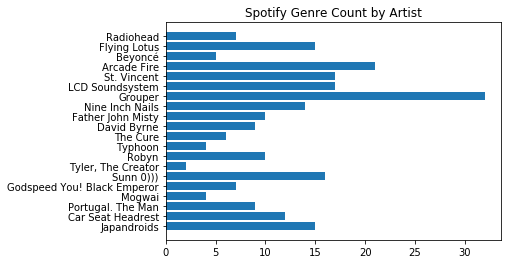

In [7]:
print("Classifying artists...")

genres_by_artist_df = pd.DataFrame(columns=['ARTIST_NAME'])
artist_count = 1

for g in GENRE_LIST:
    genres_by_artist_df[str(g).upper()] = ""
   
artist_prog = int(ARTIST_COUNT / ARTIST_COUNT)
with tqdm(total=ARTIST_COUNT) as pbar:
    for r in range(0, artists_df_rows):
        artist_name = artists_df.loc[r, 'ARTIST_NAME']
        genres_by_artist_df.loc[r, 'ARTIST_NAME'] = artist_name
        for g in GENRE_LIST:
            g_name = str(g)
            g_col = str(g).upper()
            if g_name in artists_df.loc[r, 'GENRES']:
                genres_by_artist_df.loc[r, g_col] = 1
            else:
                genres_by_artist_df.loc[r, g_col] = 0
        pbar.update(artist_prog)
        artist_count = artist_count + 1
    genres_by_artist_df.set_index('ARTIST_NAME', inplace=True)

print("SUCCESS: Artist classification complete")
display(HTML(genres_by_artist_df.to_html()))

artist_names = []
genre_counts = []

for a in reversed(ARTIST_LIST):
    artist_names.append(a)
    genre_sum = genres_by_artist_df.loc[a].sum()
    genre_counts.append(genre_sum)
    
plt.title("Spotify Genre Count by Artist")
graph = plt.barh(artist_names, genre_counts)

#### Analyze artist similarities by Spotify genre & plot recommendations by Spotify genre similarity

Preparing artist recommendations...



SUCCESS: Artist recommendations prepared


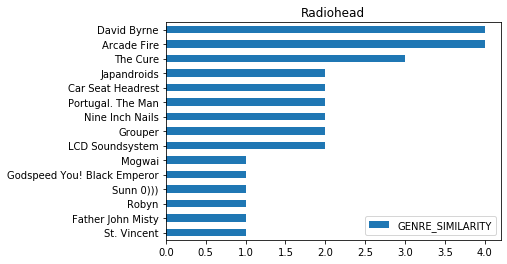

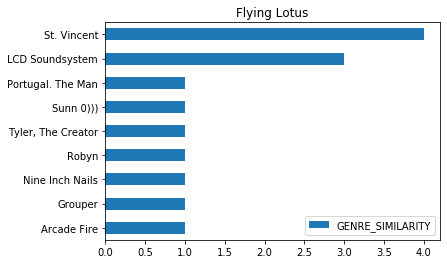

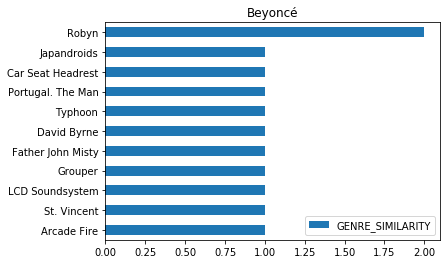

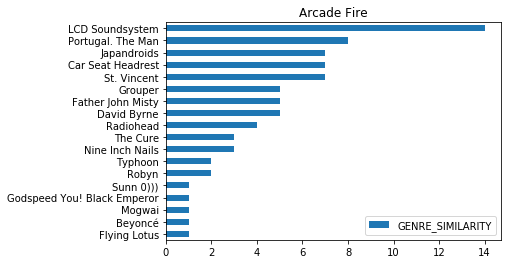

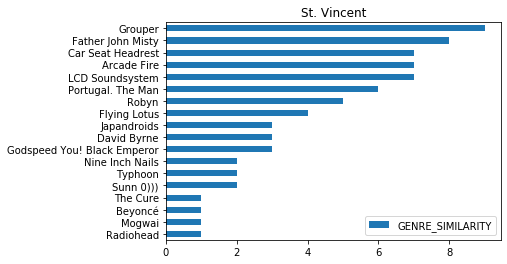

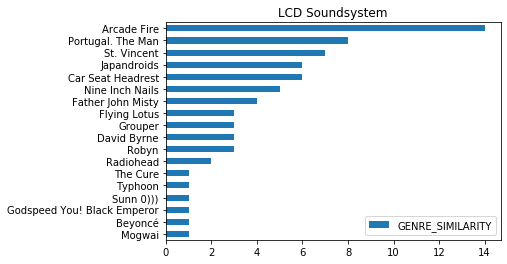

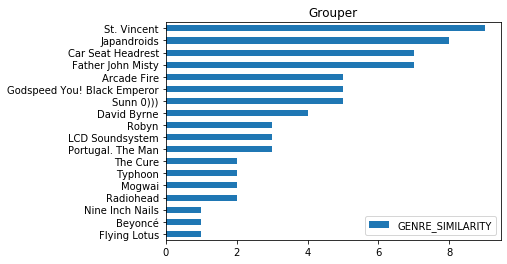

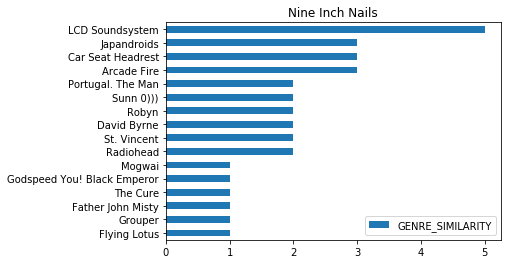

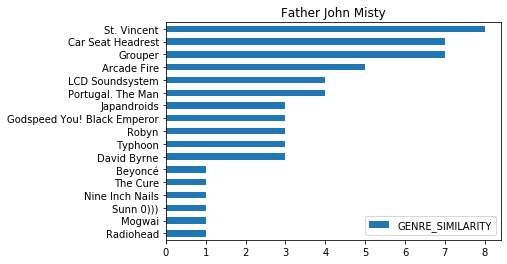

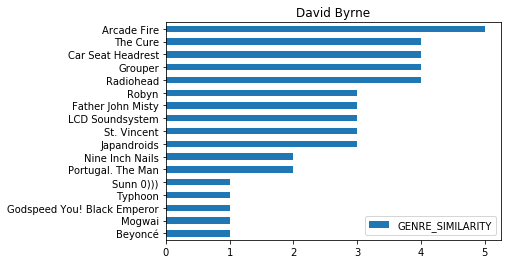

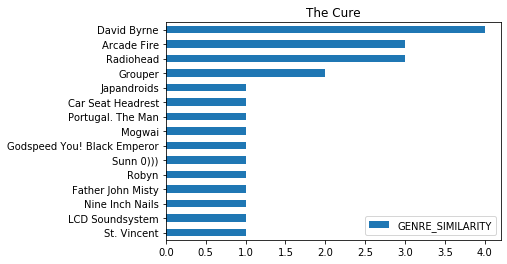

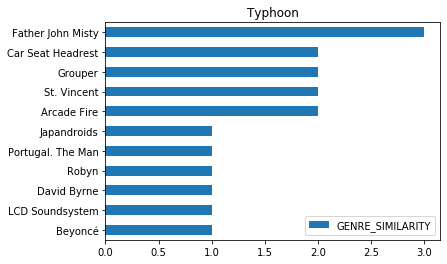

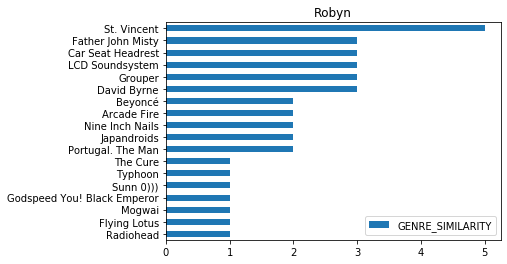

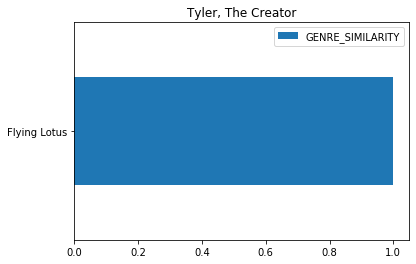

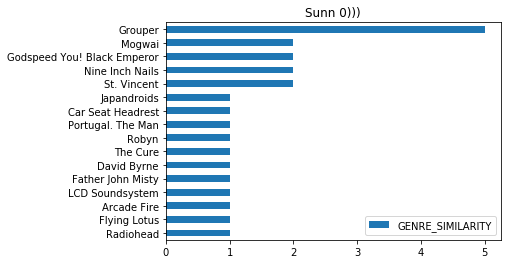

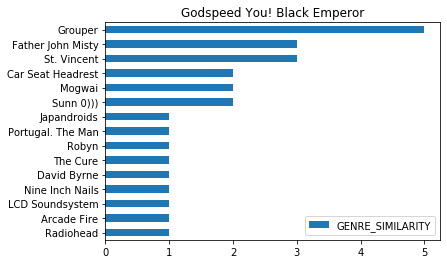

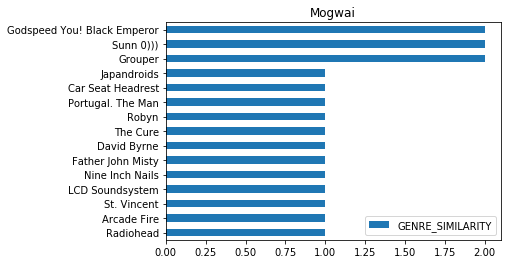

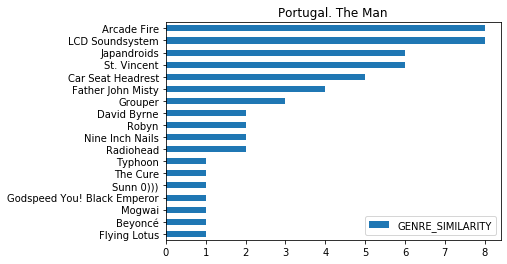

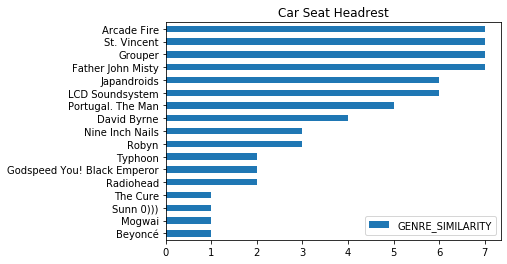

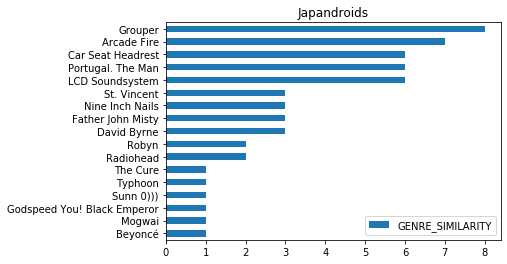

In [8]:
if RECOMMEND_ARTISTS == True:
    print("Preparing artist recommendations...")

    # Drop any genre that contains no artists
    genres_by_artist_df_nz = genres_by_artist_df.loc[:, (genres_by_artist_df != 0).any(axis=0)]
    genre_cols = list(genres_by_artist_df_nz)

    artist_recs_df = pd.DataFrame(columns=['ARTIST_NAME','ARTIST_REC', 'GENRE_SIMILARITY'])
    artist_count = 1
    row = 0

    artist_prog = int(ARTIST_COUNT / ARTIST_COUNT)
    with tqdm(total=ARTIST_COUNT) as pbar:
        for a1 in ARTIST_LIST:
            for a2 in ARTIST_LIST:
                if a1 != a2:
                    genre_count = 0
                    artist_recs_df.loc[row, 'ARTIST_NAME'] = a1
                    artist_recs_df.loc[row, 'ARTIST_REC'] = a2
                    for g in genre_cols:
                        a1_genre = genres_by_artist_df_nz.loc[a1, g]
                        a2_genre = genres_by_artist_df_nz.loc[a2, g]
                        if a1_genre == a2_genre == 1:
                            genre_count = genre_count + 1
                        else:
                            genre_count = genre_count
                        artist_recs_df.loc[row, 'GENRE_SIMILARITY'] = genre_count
                    row = row + 1
            #print("{}|{}".format(artist_count, a1))
            pbar.update(artist_prog)
            artist_count = artist_count + 1

    print("SUCCESS: Artist recommendations prepared")
    for a in ARTIST_LIST:
        try:
            df_a = artist_recs_df[artist_recs_df.ARTIST_NAME==a]
            df_a = df_a[df_a.GENRE_SIMILARITY > 0]
            df_a = df_a.sort_values('GENRE_SIMILARITY', ascending=True)
            df_a.plot.barh('ARTIST_REC', 'GENRE_SIMILARITY', title=a).set_ylabel("")
        except:
            print("{}: 0 recommendations".format(a))
    #display(HTML(artist_recs_df.to_html())) 
else:
    print("Skipping artist recommendations")
    print("DONE")